**Set Environment**

In [1]:
suppressMessages(suppressWarnings(source("config_sing.R")))

## Import

In [2]:
fdiry = file.path(FD_RES, "model_linear")
fname = "res_interactive_target_PER1.rds"
fpath = file.path(fdiry, fname)
lst_res = readRDS(fpath)

In [3]:
print(length(lst_res))
print(head(names(lst_res)))
cat("++++++++++++++++++++++++++++++++\n")
tmp = lst_res[[1]]
print(tmp)
cat("++++++++++++++++++++++++++++++++\n")
print(coef(tmp))

[1] 28680
[1] "AHR|AIRE"   "AHR|AP1_1"  "AHR|AP1_2"  "AHR|BATF"   "AHR|BCL6_1"
[6] "AHR|BCL6_2"
++++++++++++++++++++++++++++++++

Call:
lm(formula = y ~ X + 0)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.040e-06 -2.952e-07  3.540e-09  2.951e-07  1.769e-06 

Coefficients: (2 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
X(Intercept)         3.314e-06  4.762e-07   6.959 4.58e-06 ***
XXTFX_DMSO_AHR       7.530e-06  7.143e-07  10.542 2.48e-08 ***
XXTFX_DMSO_AIRE     -3.081e-06  7.776e-07  -3.962  0.00125 ** 
XXTFX_Dex_AHR        6.559e-06  7.529e-07   8.711 2.97e-07 ***
XXTFX_Dex_AIRE      -9.053e-08  8.132e-07  -0.111  0.91284    
XXTFX_DMSO_AHR_AIRE         NA         NA      NA       NA    
XXTFX_Dex_AHR_AIRE          NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.065e-06 on 15 degrees of freedom
Multiple R-squared:  0.9903,

In [4]:
lst_motif_pair = head(names(lst_res))
list(lst_motif_pair)

[[1]]
[1] "AHR|AIRE"   "AHR|AP1_1"  "AHR|AP1_2"  "AHR|BATF"   "AHR|BCL6_1"
[6] "AHR|BCL6_2"

## Get the motif pair with other columns as different stats

In [5]:
dat_motif_pair = names(lst_res)
dat_motif_pair = sapply(dat_motif_pair, function(x){
    res = str_split(string = x, pattern = "\\|", simplify = TRUE)
    return(res)
})
dat_motif_pair = as.data.frame(t(dat_motif_pair))
colnames(dat_motif_pair) = c("motif1", "motif2")
head(dat_motif_pair)

,motif1,motif2
,<chr>,<chr>
AHR|AIRE,AHR,AIRE
AHR|AP1_1,AHR,AP1_1
AHR|AP1_2,AHR,AP1_2
AHR|BATF,AHR,BATF
AHR|BCL6_1,AHR,BCL6_1
AHR|BCL6_2,AHR,BCL6_2


In [7]:
###
lst = lapply(lst_res, function(res){
    tmp = coef(res)
    if (nrow(tmp) < 7){
        return(c(NA, NA, NA))
    } else {
        return(tmp[7, c(1, 3, 4)])
    }
})
dat_values = do.call(rbind, lst)
head(dat_values)

,Estimate,t value,Pr(>|t|)
AHR|AIRE,NA,NA,NA
AHR|AP1_1,-1.255152e-05,-8.900431,9.614861e-09
AHR|AP1_2,-2.956587e-05,-13.348820,5.007554e-12
AHR|BATF,-3.574770e-05,-15.165764,8.702568e-13
AHR|BCL6_1,NA,NA,NA
AHR|BCL6_2,-1.192764e-05,-5.767914,8.396342e-06


In [48]:
dat  = cbind(dat_motif_pair, dat_values) %>% as.data.frame
idx1 = (dat$motif1 == "NR_20")
idx2 = (dat$motif2 == "NR_20")
idx  = idx1 + idx2
dat$color = ifelse(idx > 0, "red", "grey50")

dat = dat %>% mutate(AP1_1_NR_20 = (motif1 == "AP1_1" & motif2 == "NR_20"))

###
dat$adj_pval = p.adjust(dat$`Pr(>|t|)`, method = "BH")
dat$nlogpval = -log10(dat$`Pr(>|t|)`)

dat_res = dat
head(dat_res)

,motif1,motif2,Estimate,t value,Pr(>|t|),color,AP1_1_NR_20,adj_pval,nlogpval
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>
AHR|AIRE,AHR,AIRE,NA,NA,NA,grey50,FALSE,NA,NA
AHR|AP1_1,AHR,AP1_1,-1.255152e-05,-8.900431,9.614861e-09,grey50,FALSE,1.946946e-08,8.017057
AHR|AP1_2,AHR,AP1_2,-2.956587e-05,-13.348820,5.007554e-12,grey50,FALSE,2.557841e-11,11.300374
AHR|BATF,AHR,BATF,-3.574770e-05,-15.165764,8.702568e-13,grey50,FALSE,7.265456e-12,12.060353
AHR|BCL6_1,AHR,BCL6_1,NA,NA,NA,grey50,FALSE,NA,NA
AHR|BCL6_2,AHR,BCL6_2,-1.192764e-05,-5.767914,8.396342e-06,grey50,FALSE,1.224592e-05,5.075910


## volcano plot

In [49]:
dat = dat_res %>% na.omit
tmp = dat %>% dplyr::filter(color == "red")

gpt = ggplot(dat, aes(x=Estimate, y=-log10(adj_pval))) + 
    geom_point(size=1, color=dat$color) +
    geom_point(size=1, 
               color="red",
               aes(x=Estimate, y=-log10(adj_pval)),
               data = tmp) +
    geom_hline(yintercept = 2, color="red", alpha=0.5) +
    labs(x="Estimate", y="-log10(adj. p-value (BH))") +
    theme_bw() +
    theme(
        axis.text.x        = element_text(size=10),
        axis.text.y        = element_text(size=10),
        axis.text.y.right  = element_text(size=10),
        axis.title.x       = element_text(size=12),
        axis.title.y       = element_text(size=12),
        axis.title.y.right = element_text(size=12)
    )

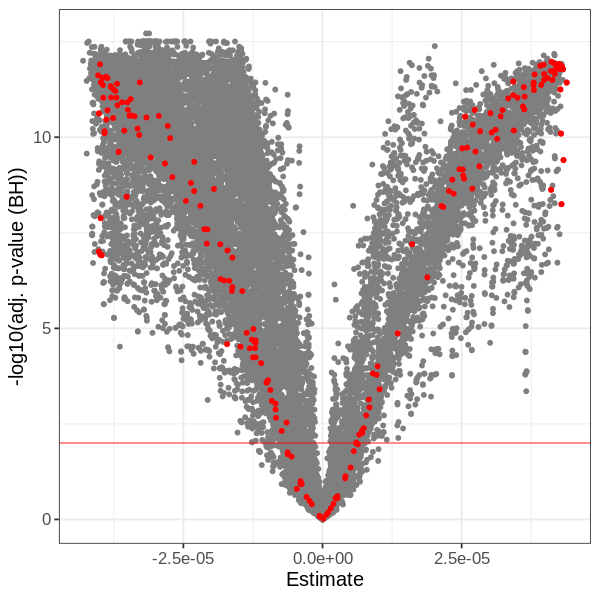

In [50]:
options(repr.plot.width=5, repr.plot.height=5)
print(gpt)

In [51]:
dat = dat_res %>% na.omit
tmp = dat %>% dplyr::filter(AP1_1_NR_20)

gpt = ggplot(dat, aes(x=Estimate, y=-log10(adj_pval))) + 
    geom_point(size=1, color="grey50") +
    geom_point(size=1, 
               color="red",
               aes(x=Estimate, y=-log10(adj_pval)),
               data = tmp) +
    geom_hline(yintercept = 2, color="red", alpha=0.5) +
    labs(x="Estimate", y="-log10(adj. p-value (BH))") +
    theme_bw() +
    theme(
        axis.text.x        = element_text(size=10),
        axis.text.y        = element_text(size=10),
        axis.text.y.right  = element_text(size=10),
        axis.title.x       = element_text(size=12),
        axis.title.y       = element_text(size=12),
        axis.title.y.right = element_text(size=12)
    )

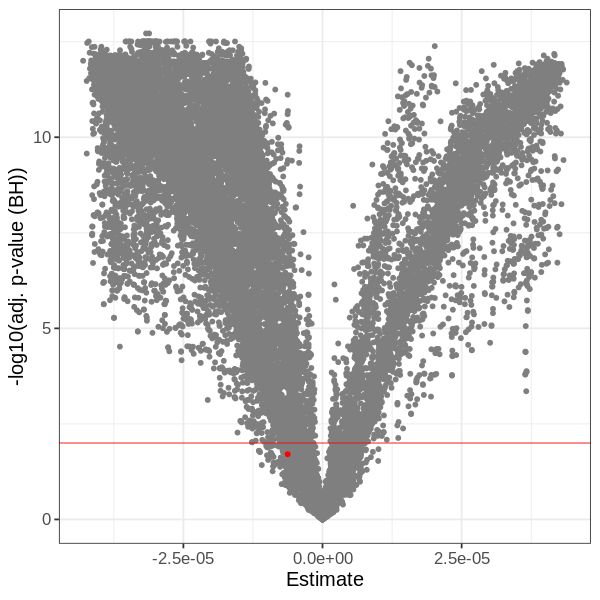

In [52]:
options(repr.plot.width=5, repr.plot.height=5)
print(gpt)

## Heatmap

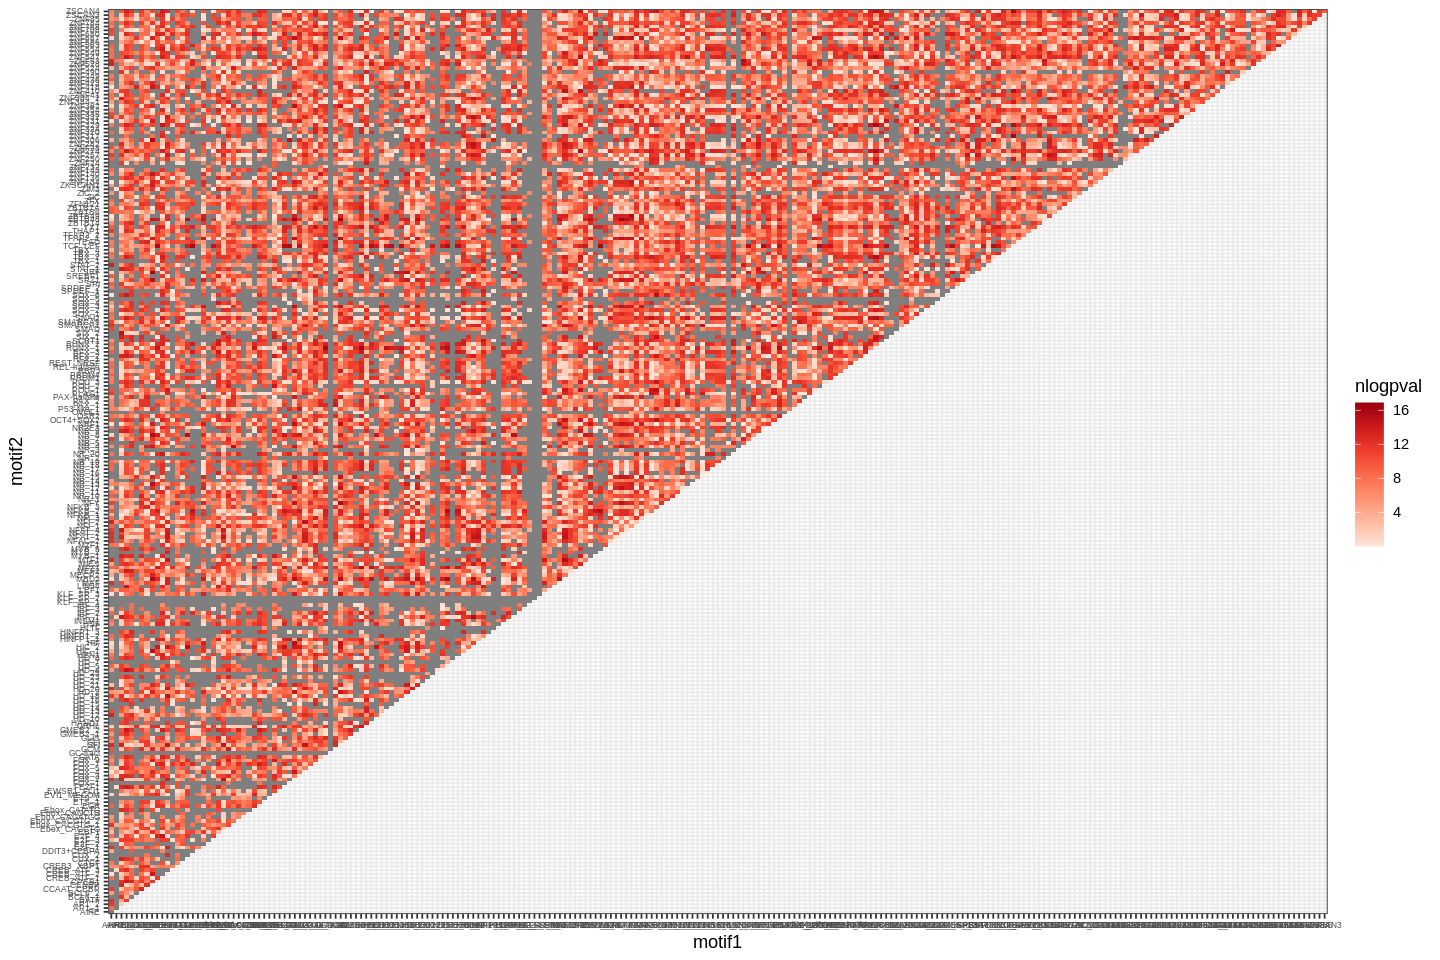

In [12]:
dat = dat_res
gpt = ggplot(dat, aes(x=motif1, y=motif2, fill=nlogpval)) + 
    geom_tile() + 
    theme_bw() +
    theme(axis.text = element_text(size=5)) +
    scale_fill_distiller(palette="Reds", direction=1)

options(repr.plot.height=8, repr.plot.width=12)
print(gpt)

In [15]:
tmp = dat_res
mat = tmp %>% dplyr::select(motif1, motif2, nlogpval) %>% spread(motif2, nlogpval)
mat = column_to_rownames(mat, var = "motif1")

idx = colnames(mat)
mat = mat[idx,]
mat[is.na(mat)] = 0
mat = mat + t(mat)
mat_ori = mat
head(mat_ori)

,AIRE,AP1_1,AP1_2,BATF,BCL6_1,BCL6_2,CCAAT_CEBP,CENBP,CPEB1,CREB_ATF_1,⋯,ZNF563,ZNF586,ZNF667,ZNF680,ZNF708,ZNF768,ZNF784,ZNF85,ZSCAN3,ZSCAN4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AIRE,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,⋯,0.000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,0.000000,6.7839383,0.000000,0.000000
AP1_1,0,0.000000,1.714571,4.343079,11.652807,8.738019,1.710471,13.243796,11.908866,2.723709,⋯,1.326866,4.20664125,1.301059,1.144669,7.1473006,1.930428,8.316153,0.8834955,2.102077,9.705716
AP1_2,0,1.714571,0.000000,11.413150,3.089492,5.831577,7.363987,1.028557,13.950889,11.668202,⋯,11.274102,7.24819220,4.679425,12.702764,1.7909240,10.293806,12.377718,6.9823534,11.484855,13.472343
BATF,0,4.343079,11.413150,0.000000,0.000000,2.648106,5.736060,3.671698,12.978764,9.002033,⋯,10.218820,8.82695142,6.929978,10.702050,0.6158116,8.273363,10.268658,4.9043288,9.494216,11.665466
BCL6_1,0,11.652807,3.089492,0.000000,0.000000,0.000000,9.864745,8.660269,8.633179,1.578788,⋯,0.000000,4.00832248,11.924521,0.000000,0.2509342,0.000000,0.000000,1.1083632,1.283243,0.000000
BCL6_2,0,8.738019,5.831577,2.648106,0.000000,0.000000,13.011607,2.544710,11.489269,10.359808,⋯,10.342375,0.03130959,6.693792,8.354272,4.4609897,8.636558,10.929884,6.9657866,10.091405,11.200548


In [16]:
idx = apply(mat_ori, 1, mean)
idx = (idx > 5)
mat_fil = mat_ori[idx, idx]
print(dim(mat_fil))
print(which(colnames(mat_fil) == "NR_20"))
print(which(colnames(mat_fil) == "AP1_1"))
head(mat_fil)

[1] 172 172
[1] 79
[1] 1


,AP1_1,AP1_2,BATF,BCL6_2,CCAAT_CEBP,CENBP,CREB_ATF_1,CREB_ATF_2,CREB3_XBP1,E2F_1,⋯,ZNF563,ZNF586,ZNF667,ZNF680,ZNF708,ZNF768,ZNF784,ZNF85,ZSCAN3,ZSCAN4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AP1_1,0.000000,1.714571,4.343079,8.738019,1.710471,13.243796,2.7237088,1.755819,8.399458,10.867295,⋯,1.32686596,4.20664125,1.3010594,1.144669,7.1473006,1.9304282,8.316153,0.8834955,2.1020770,9.705716
AP1_2,1.714571,0.000000,11.413150,5.831577,7.363987,1.028557,11.6682021,5.196484,5.749546,3.537247,⋯,11.27410189,7.24819220,4.6794249,12.702764,1.7909240,10.2938056,12.377718,6.9823534,11.4848548,13.472343
BATF,4.343079,11.413150,0.000000,2.648106,5.736060,3.671698,9.0020335,8.759860,2.227492,7.115059,⋯,10.21881998,8.82695142,6.9299777,10.702050,0.6158116,8.2733631,10.268658,4.9043288,9.4942160,11.665466
BCL6_2,8.738019,5.831577,2.648106,0.000000,13.011607,2.544710,10.3598076,7.917286,12.012631,6.031403,⋯,10.34237516,0.03130959,6.6937925,8.354272,4.4609897,8.6365583,10.929884,6.9657866,10.0914048,11.200548
CCAAT_CEBP,1.710471,7.363987,5.736060,13.011607,0.000000,12.362667,8.5084674,1.522692,11.825227,10.577416,⋯,7.55420684,5.80514585,0.7177175,8.308370,8.2379408,7.4429232,3.992773,8.9765719,7.4689670,6.593384
CENBP,13.243796,1.028557,3.671698,2.544710,12.362667,0.000000,0.2115432,14.220312,4.545238,8.856043,⋯,0.04354398,1.62265143,13.4061313,0.263111,3.1620454,0.2092935,11.560866,4.7428108,0.1794211,10.501115


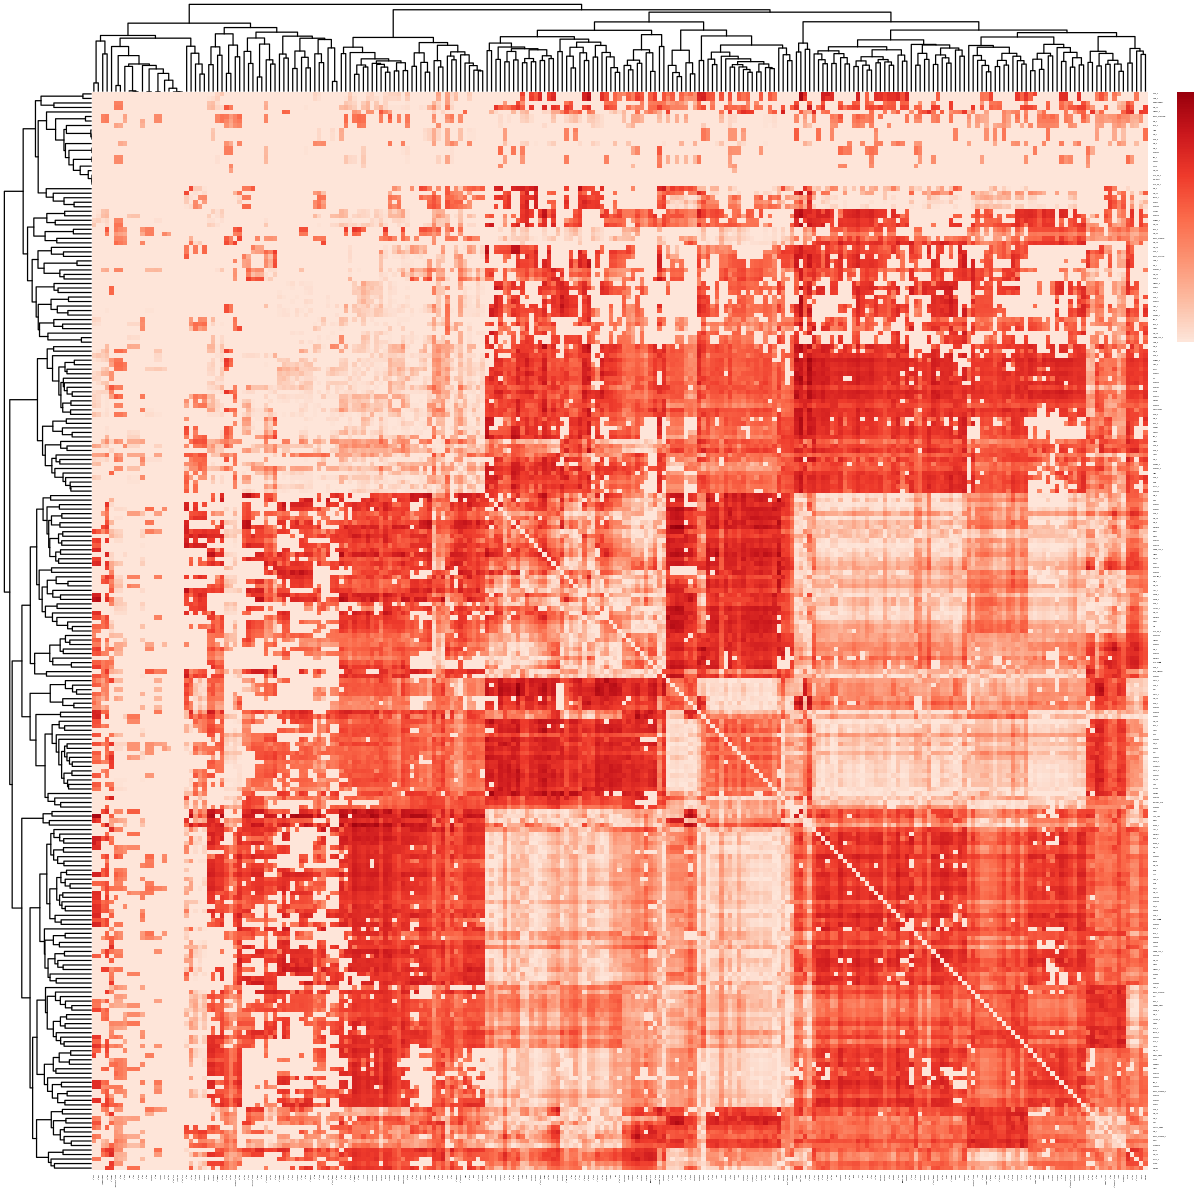

In [17]:
options(repr.plot.width=10, repr.plot.height=10)
out = pheatmap(
    mat_ori, 
    fontsize = 1,
    color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

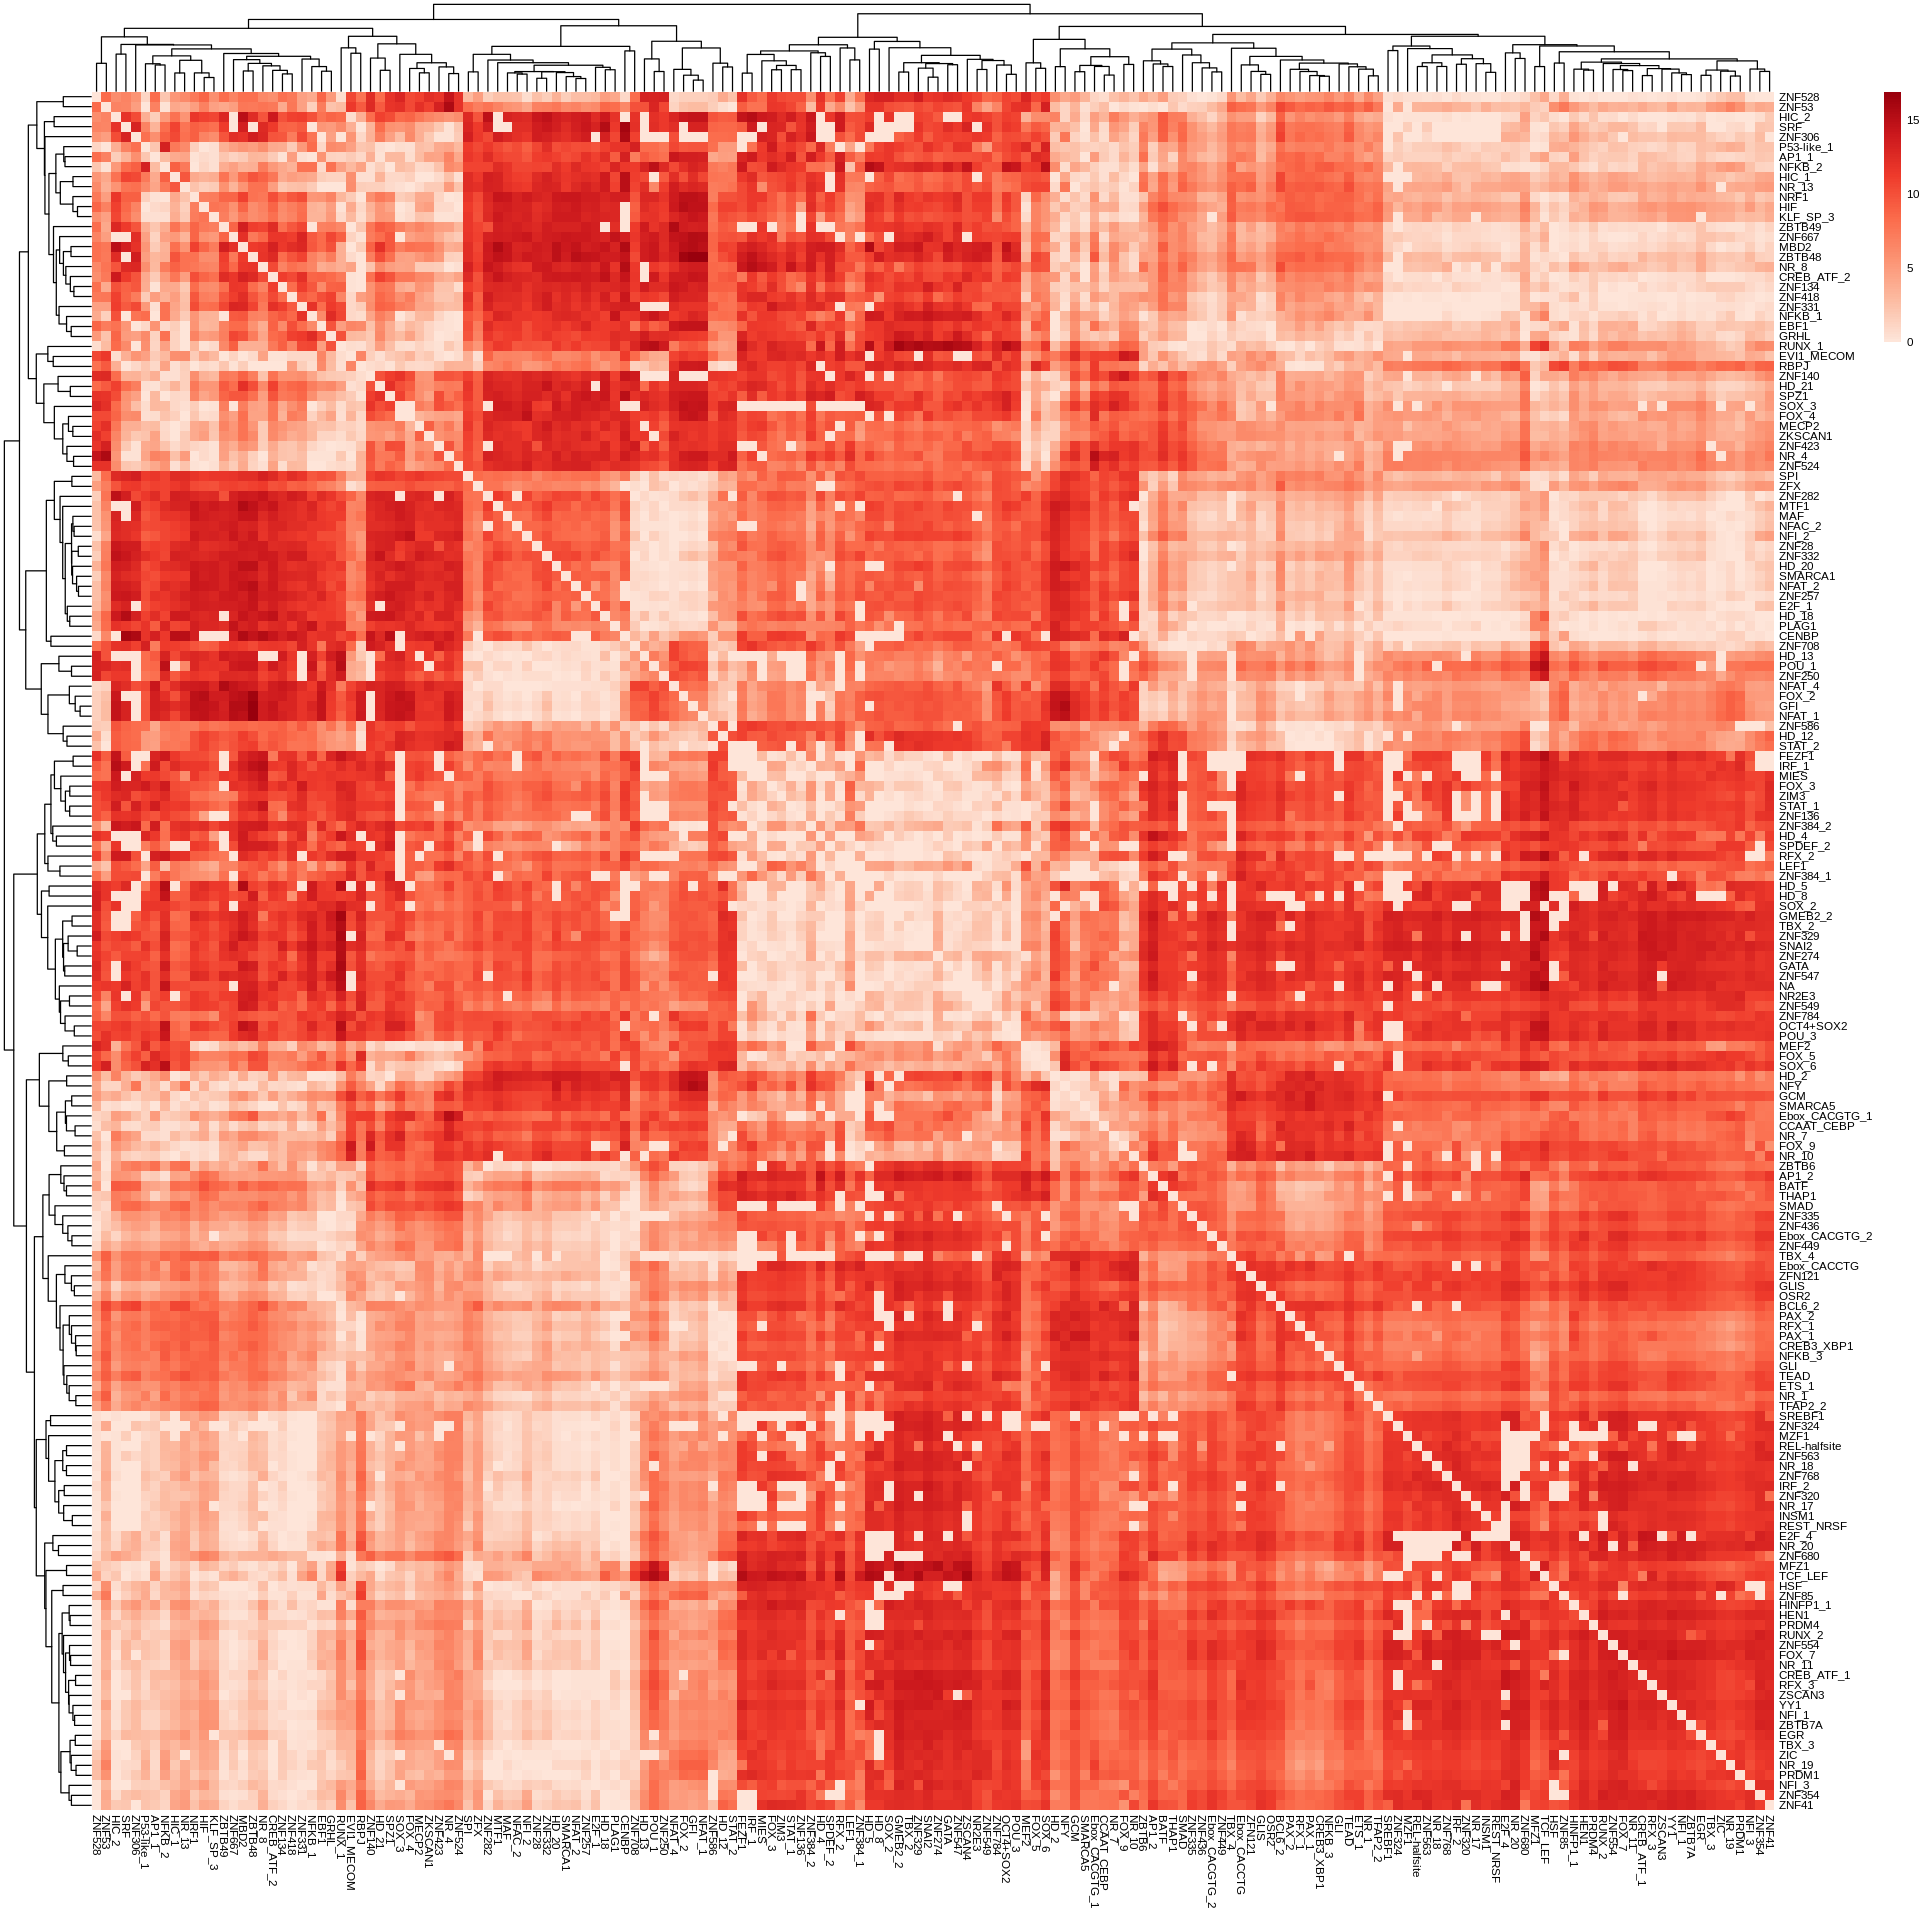

In [18]:
options(repr.plot.width=16, repr.plot.height=16)
out = pheatmap(
    mat_fil, 
    fontsize = 7,
    color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

In [19]:
idx = rownames(mat_fil[out$tree_row[["order"]],])
mat_fil["NR_20", out$tree_col[["order"]]]

,ZNF528,ZNF53,HIC_2,SRF,ZNF306,P53-like_1,AP1_1,NFKB_2,HIC_1,NR_13,⋯,NFI_1,ZBTB7A,EGR,TBX_3,ZIC,NR_19,PRDM1,NFI_3,ZNF354,ZNF41
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NR_20,0.4302707,2.403367,0.9776778,2.97806,3.695056,1.821508,1.77433,0.6196917,4.379022,4.671785,⋯,13.31541,13.31915,13.0975,12.63468,12.20636,12.52803,12.40701,13.20973,12.93887,12.93054


In [20]:
print(length(idx))
print(which(colnames(mat_fil)[out$tree_col[["order"]]] == "NR_20"))

[1] 172
[1] 146


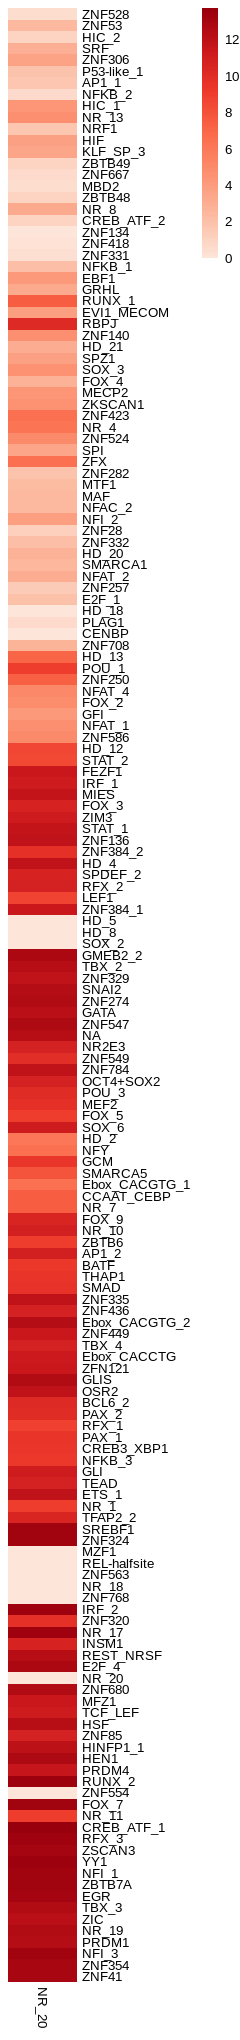

In [21]:
options(repr.plot.width=2, repr.plot.height=17)
pheatmap(mat_fil[out$tree_row[["order"]], "NR_20", drop=FALSE], 
         cluster_cols = FALSE, cluster_rows = FALSE,
         fontsize = 8,
         color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

In [22]:
lst_res["AP1_1|NR_20"]

$`AP1_1|NR_20`

Call:
lm(formula = y ~ X + 0)

Residuals:
       Min         1Q     Median         3Q        Max 
-3.019e-06 -7.286e-07 -6.300e-08  4.118e-07  5.841e-06 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
X(Intercept)            7.290e-06  8.841e-07   8.246 3.56e-08 ***
XXTFX_DMSO_AP1_1       -2.871e-06  1.326e-06  -2.165   0.0415 *  
XXTFX_DMSO_NR_20       -9.442e-08  1.326e-06  -0.071   0.9439    
XXTFX_Dex_AP1_1        -1.073e-06  1.398e-06  -0.767   0.4510    
XXTFX_Dex_NR_20         2.381e-05  1.398e-06  17.032 3.71e-14 ***
XXTFX_DMSO_AP1_1_NR_20  5.069e-07  1.927e-06   0.263   0.7949    
XXTFX_Dex_AP1_1_NR_20  -6.264e-06  2.421e-06  -2.587   0.0168 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.977e-06 on 22 degrees of freedom
Multiple R-squared:  0.9866,	Adjusted R-squared:  0.9824 
F-statistic: 232.1 on 7 and 22 DF,  p-value: < 2.2e-16



In [30]:
head(dat)

,motif1,motif2,Estimate,t value,Pr(>|t|),color,AP1_1_NR_20,adj_pval,nlogpval
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>
AHR|AP1_1,AHR,AP1_1,-1.255152e-05,-8.900431,9.614861e-09,grey50,FALSE,1.946946e-08,8.017057
AHR|AP1_2,AHR,AP1_2,-2.956587e-05,-13.348820,5.007554e-12,grey50,FALSE,2.557841e-11,11.300374
AHR|BATF,AHR,BATF,-3.574770e-05,-15.165764,8.702568e-13,grey50,FALSE,7.265456e-12,12.060353
AHR|BCL6_2,AHR,BCL6_2,-1.192764e-05,-5.767914,8.396342e-06,grey50,FALSE,1.224592e-05,5.075910
AHR|CCAAT_CEBP,AHR,CCAAT_CEBP,-1.614384e-05,-13.307297,5.324117e-12,grey50,FALSE,2.681351e-11,11.273752
AHR|CREB_ATF_1,AHR,CREB_ATF_1,-2.212897e-05,-9.399795,8.865488e-09,grey50,FALSE,1.804909e-08,8.052297
